In [24]:
import os
import re
import math
import warnings
warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import kaleido
import ipywidgets as widgets
from plotly.subplots import make_subplots
from IPython.display import display, Image

# Statistical analysis
from scipy.stats import boxcox, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ML libraries and utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Hyperparameter tuning
import xgboost as xgb
import optuna
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Data Overview

In [25]:
def load_stock_data(tickers, data_dir='data/'):
    stock_data = {}
    for ticker in tickers:
        file_path = os.path.join(data_dir, f'{ticker}.csv')
        try:
            df = pd.read_csv(file_path)
            df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
            df['DayOfWeek'] = df['Date'].dt.dayofweek
            df['DayName'] = df['Date'].dt.day_name()
            stock_data[ticker] = df
            logging.info(f'{ticker} data loaded successfully.')
        except Exception as e:
            logging.error(f'Error loading {ticker} data: {e}')
    return stock_data

In [26]:
stock_tickers = ['DNUT', 'MCD', 'DPZ', 'PZZA', 'SBUX', 'WEN', 'YUM']
stock_data = load_stock_data(stock_tickers)

In [27]:
for ticker in stock_data:
    print(f'{ticker} data:')
    print(stock_data[ticker].head())
    print()

DNUT data:
        Date       Open       High    Low      Close  Adj Close    Volume  \
0 2021-07-01  16.299999  21.690001  15.50  21.000000  20.361467  40888200   
1 2021-07-02  19.854000  20.450001  18.32  19.120001  18.538637   8631400   
2 2021-07-06  18.900000  19.120001  17.00  17.000000  16.483095   3973000   
3 2021-07-07  17.289000  18.160000  17.00  17.780001  17.239378   3213500   
4 2021-07-08  17.250000  18.350000  17.00  18.200001  17.646606   5448300   

   DayOfWeek    DayName  
0          3   Thursday  
1          4     Friday  
2          1    Tuesday  
3          2  Wednesday  
4          3   Thursday  

MCD data:
        Date  Open      High       Low     Close  Adj Close   Volume  \
0 1966-07-05   0.0  0.273663  0.267490  0.269547   0.115991   388800   
1 1966-07-06   0.0  0.283951  0.267490  0.283951   0.122190   692550   
2 1966-07-07   0.0  0.291152  0.271605  0.273663   0.117762  1858950   
3 1966-07-08   0.0  0.276749  0.267490  0.276749   0.119090  1239300   

In [28]:
df = stock_data['MCD']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14652 entries, 0 to 14651
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14652 non-null  datetime64[ns]
 1   Open       14652 non-null  float64       
 2   High       14652 non-null  float64       
 3   Low        14652 non-null  float64       
 4   Close      14652 non-null  float64       
 5   Adj Close  14652 non-null  float64       
 6   Volume     14652 non-null  int64         
 7   DayOfWeek  14652 non-null  int32         
 8   DayName    14652 non-null  object        
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(1)
memory usage: 973.1+ KB


In [29]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'DayOfWeek', 'DayName'],
      dtype='object')

In [30]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
DayOfWeek             int32
DayName              object
dtype: object

### Time series data check and missing data analysis

Confirming dataset is time-based by checking if the dates are unique and ordered chronologically (monotonically increasing) and missing data analysis.

In [31]:
def check_chronological_order(df):
    # Check if dates are in chronological order (monotonically increasing)
    date_order_correct = df['Date'].is_monotonic_increasing
    print(f"Dates are in chronological order: {date_order_correct}")
    return date_order_correct

In [32]:
def check_missing_dates(df):
    # Generate the complete date range between the min and max date
    date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
    missing_dates = date_range.difference(df['Date'].unique())
    
    # Separate weekends (Saturdays and Sundays)
    weekend_missing = missing_dates[missing_dates.to_series().dt.dayofweek.isin([5, 6])] 
    # Separate non-weekend missing dates
    non_weekend_missing = missing_dates[~missing_dates.to_series().dt.dayofweek.isin([5, 6])]
    
    total_missing = len(missing_dates)
    weekend_missing_count = len(weekend_missing)
    non_weekend_missing_count = len(non_weekend_missing)
    missing_per_year = pd.Series(missing_dates).dt.year.value_counts().sort_index()
    average_missing_per_year = missing_per_year.mean()
    
    print(f"Total Missing Dates: {total_missing}")
    print(f"Number of weekend missing dates: {weekend_missing_count}")
    print(f"Number of non-weekend missing dates: {non_weekend_missing_count}")
    print(f"Average number of non-trading dates per year: {average_missing_per_year:.2f}")
    return total_missing, weekend_missing_count, non_weekend_missing_count, average_missing_per_year

In [34]:
def count_trading_dates_with_data(df):
    trading_dates_per_year = df['Date'].dt.year.value_counts().sort_index()
    total_trading_days_with_data = len(df)
    average_trading_days_per_year = trading_dates_per_year.mean()
    
    print(f"Total Trading Days with Data: {total_trading_days_with_data}")
    print(f"Average number of trading days per year: {average_trading_days_per_year:.2f}")
    return total_trading_days_with_data, average_trading_days_per_year

In [35]:
for ticker in stock_tickers:
    df = stock_data[ticker]
    print(f"\nTicker: {ticker}")
    check_chronological_order(df)
    check_missing_dates(df)
    count_trading_dates_with_data(df)


Ticker: DNUT
Dates are in chronological order: True
Total Missing Dates: 367
Number of weekend missing dates: 336
Number of non-weekend missing dates: 31
Average number of non-trading dates per year: 91.75
Total Trading Days with Data: 810
Average number of trading days per year: 202.50

Ticker: MCD
Dates are in chronological order: True
Total Missing Dates: 6610
Number of weekend missing dates: 6074
Number of non-weekend missing dates: 536
Average number of non-trading dates per year: 112.03
Total Trading Days with Data: 14652
Average number of trading days per year: 248.34

Ticker: DPZ
Dates are in chronological order: True
Total Missing Dates: 2291
Number of weekend missing dates: 2106
Number of non-weekend missing dates: 185
Average number of non-trading dates per year: 109.10
Total Trading Days with Data: 5083
Average number of trading days per year: 242.05

Ticker: PZZA
Dates are in chronological order: True
Total Missing Dates: 3549
Number of weekend missing dates: 3264
Number 

The dataset for each ticker is confirmed to have dates in chronological order, which is great for analysis. The missing dates correspond to weekends (e.g., Saturdays and Sundays), which is typical for stock market data since stock markets are generally closed on weekends and certain holidays.As the model doesn’t require data for non-trading days, the missing dates can be ignored. The other missing dates are non-weekend holidays when the NYSE markets observe U.S. holidays and the market is closed.The missing dates are expected non-trading days and a final check is done to confirm that no trading days are missing.

## Feature Distribution and Univariate Analysis

In [36]:
def summary_statistics_numerical_features(df, ticker):
    numerical_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df_copy = df[numerical_features].copy()
    print(f"\nSummary Statistics for {ticker}:")
    
    print(df_copy.describe())  # count, mean, std, min, 25%, 50%, 75%, max
    print("-" * 50)

In [37]:
for ticker in stock_tickers:
    summary_statistics_numerical_features(stock_data[ticker], ticker)


Summary Statistics for DNUT:
             Open        High         Low       Close   Adj Close  \
count  810.000000  810.000000  810.000000  810.000000  810.000000   
mean    13.720642   13.993102   13.467714   13.719858   13.486431   
std      1.700281    1.795572    1.630926    1.707906    1.611185   
min      9.510000    9.770000    9.180000    9.200000    9.200000   
25%     12.645000   12.891250   12.430000   12.670000   12.494866   
50%     13.855000   14.095000   13.570000   13.855000   13.565939   
75%     14.820000   15.060000   14.520000   14.807500   14.534018   
max     19.854000   21.690001   18.430000   21.000000   20.361467   

             Volume  
count  8.100000e+02  
mean   1.385002e+06  
std    2.429015e+06  
min    2.011000e+05  
25%    6.872000e+05  
50%    9.469500e+05  
75%    1.462775e+06  
max    4.360570e+07  
--------------------------------------------------

Summary Statistics for MCD:
               Open          High           Low         Close     Adj 

In [38]:
def plot_numerical_features(df, ticker):
    numerical_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(numerical_features):
        sns.histplot(df[feature], kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f"{feature} for {ticker}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

Feature Distributions for DNUT


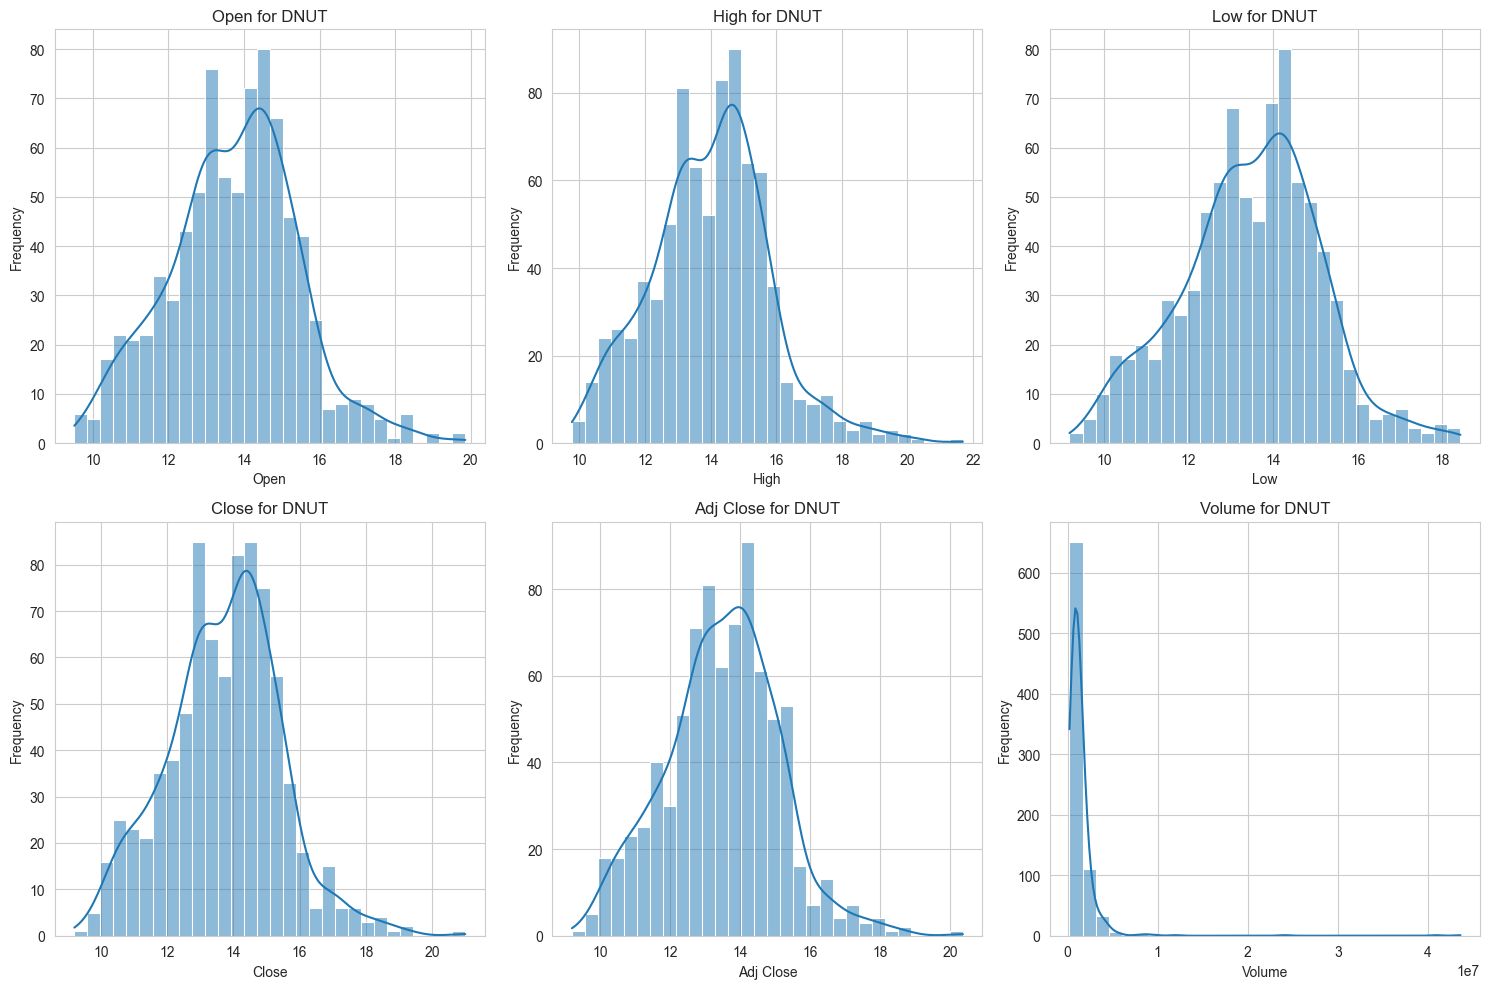

Feature Distributions for MCD


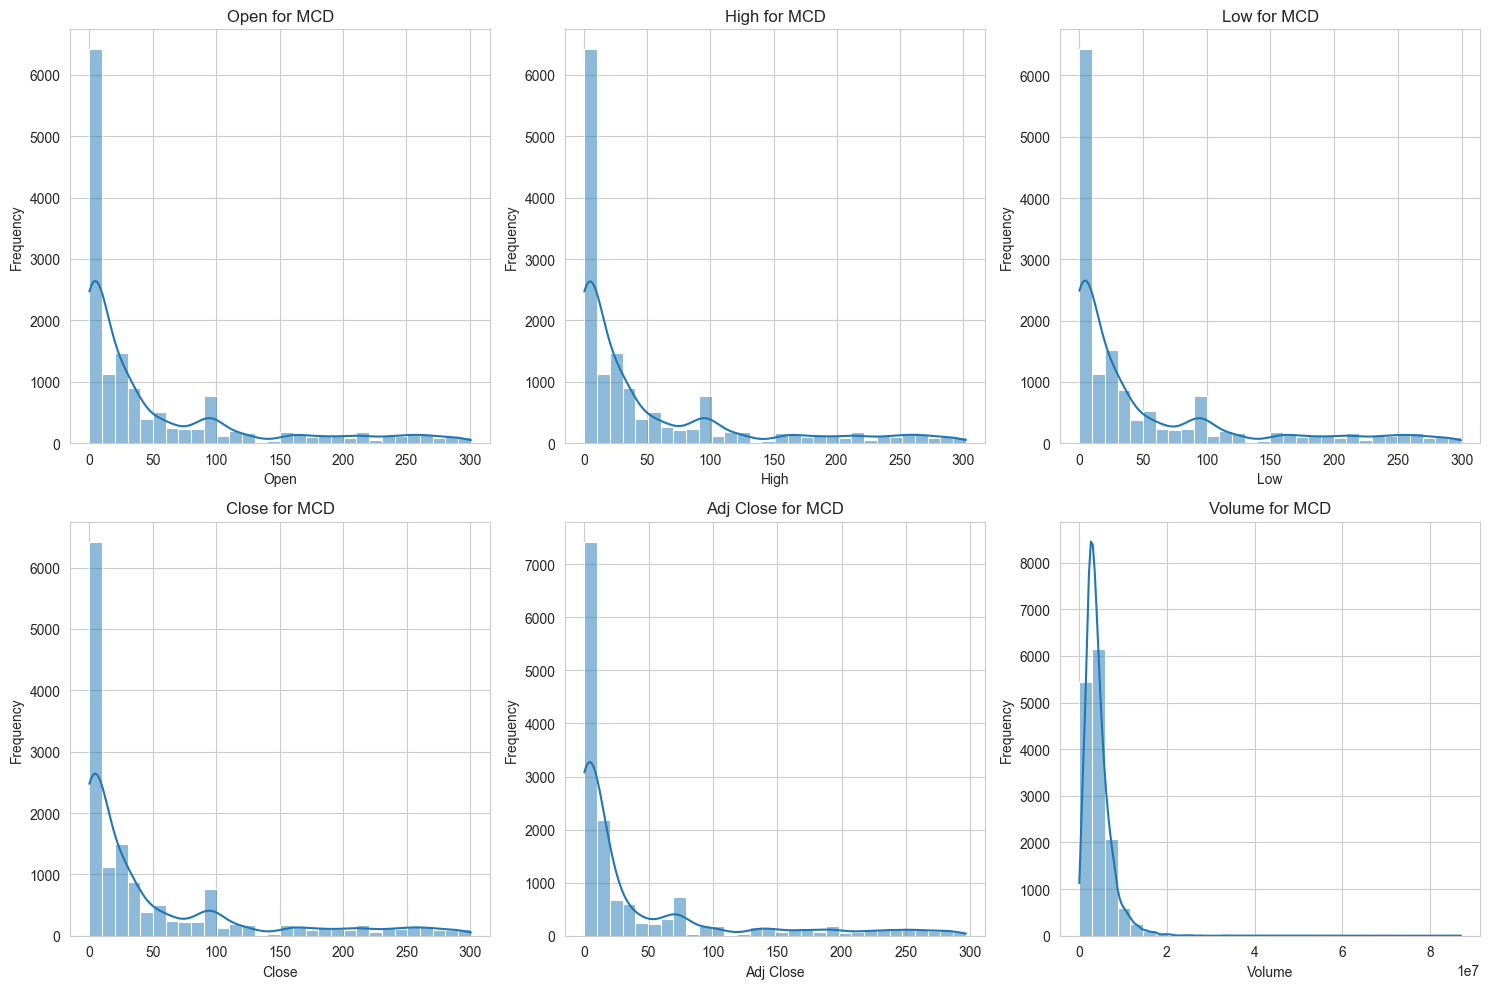

Feature Distributions for DPZ


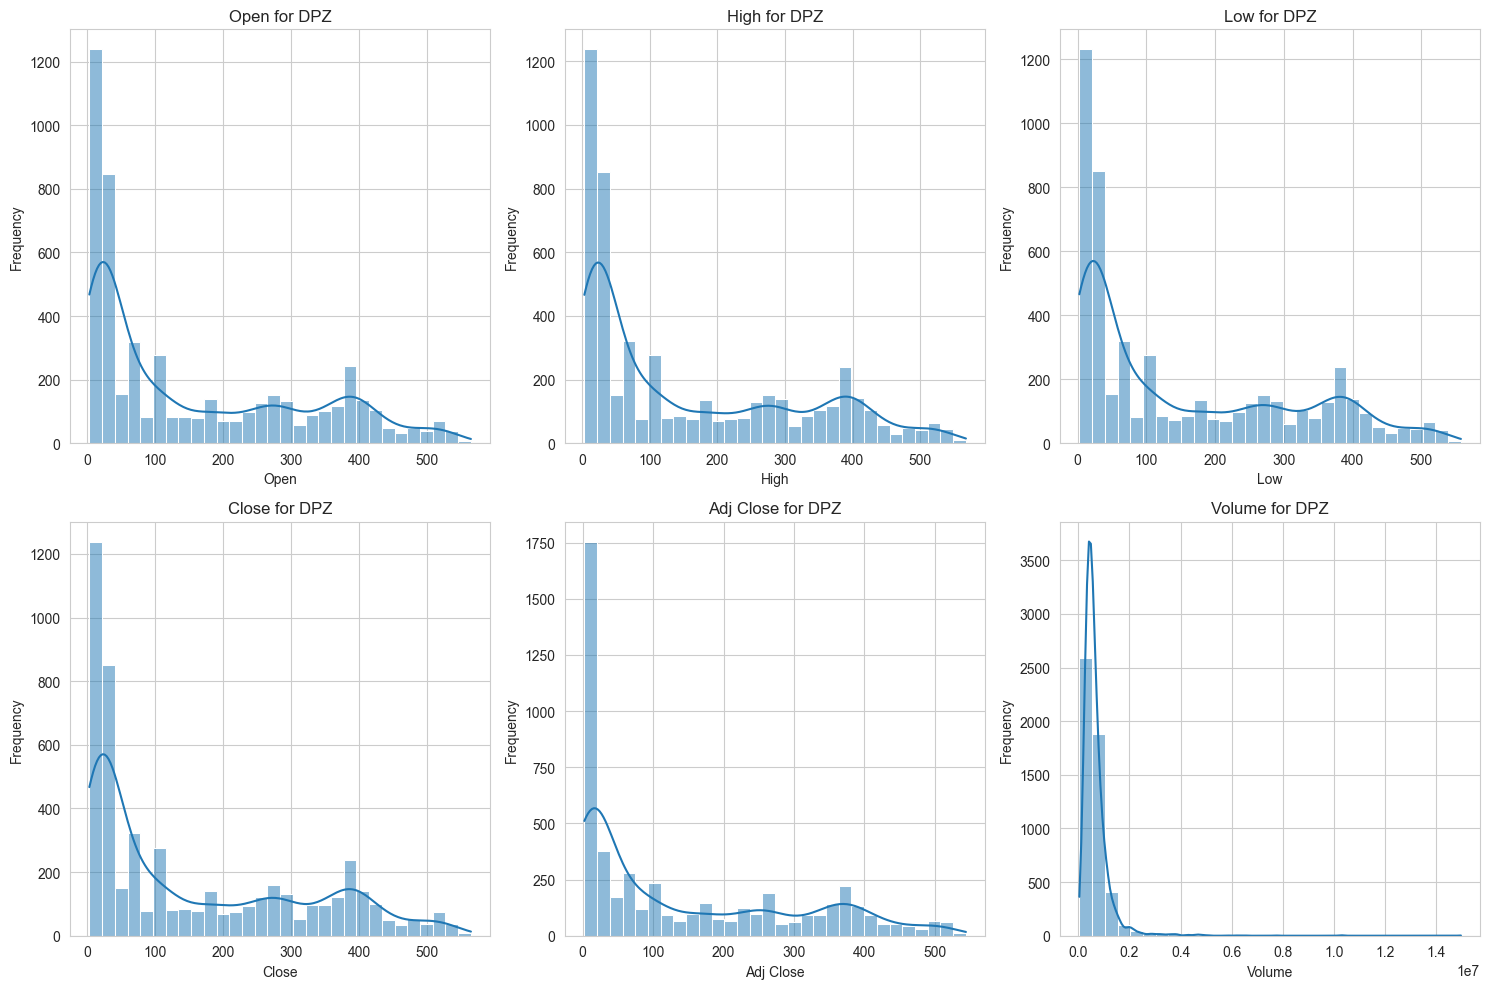

Feature Distributions for PZZA


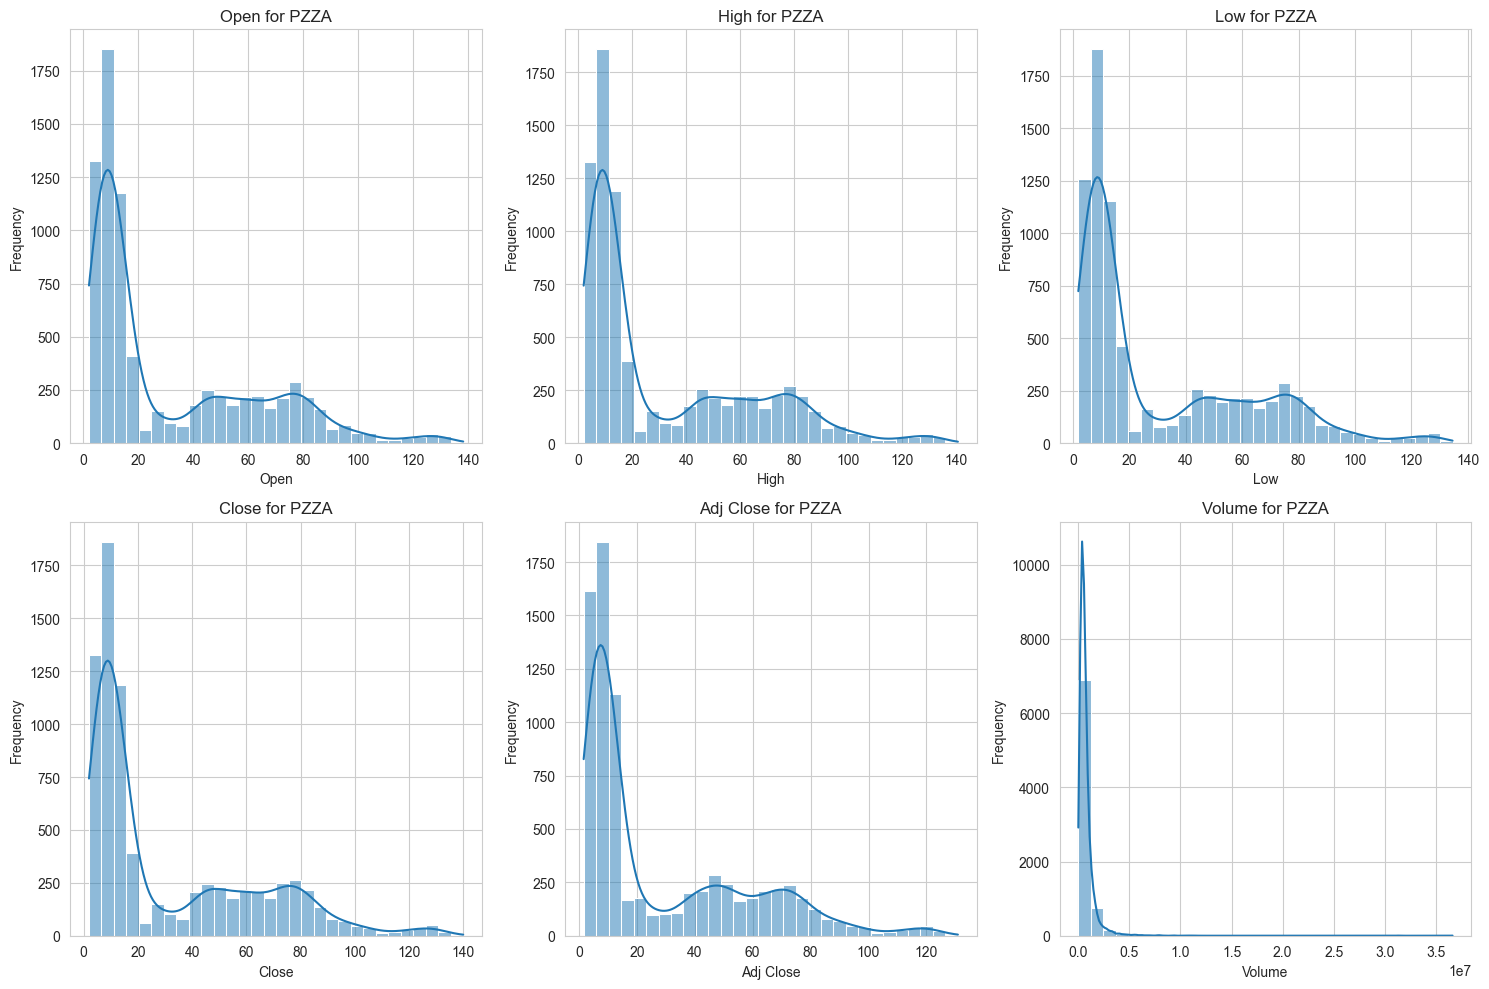

Feature Distributions for SBUX


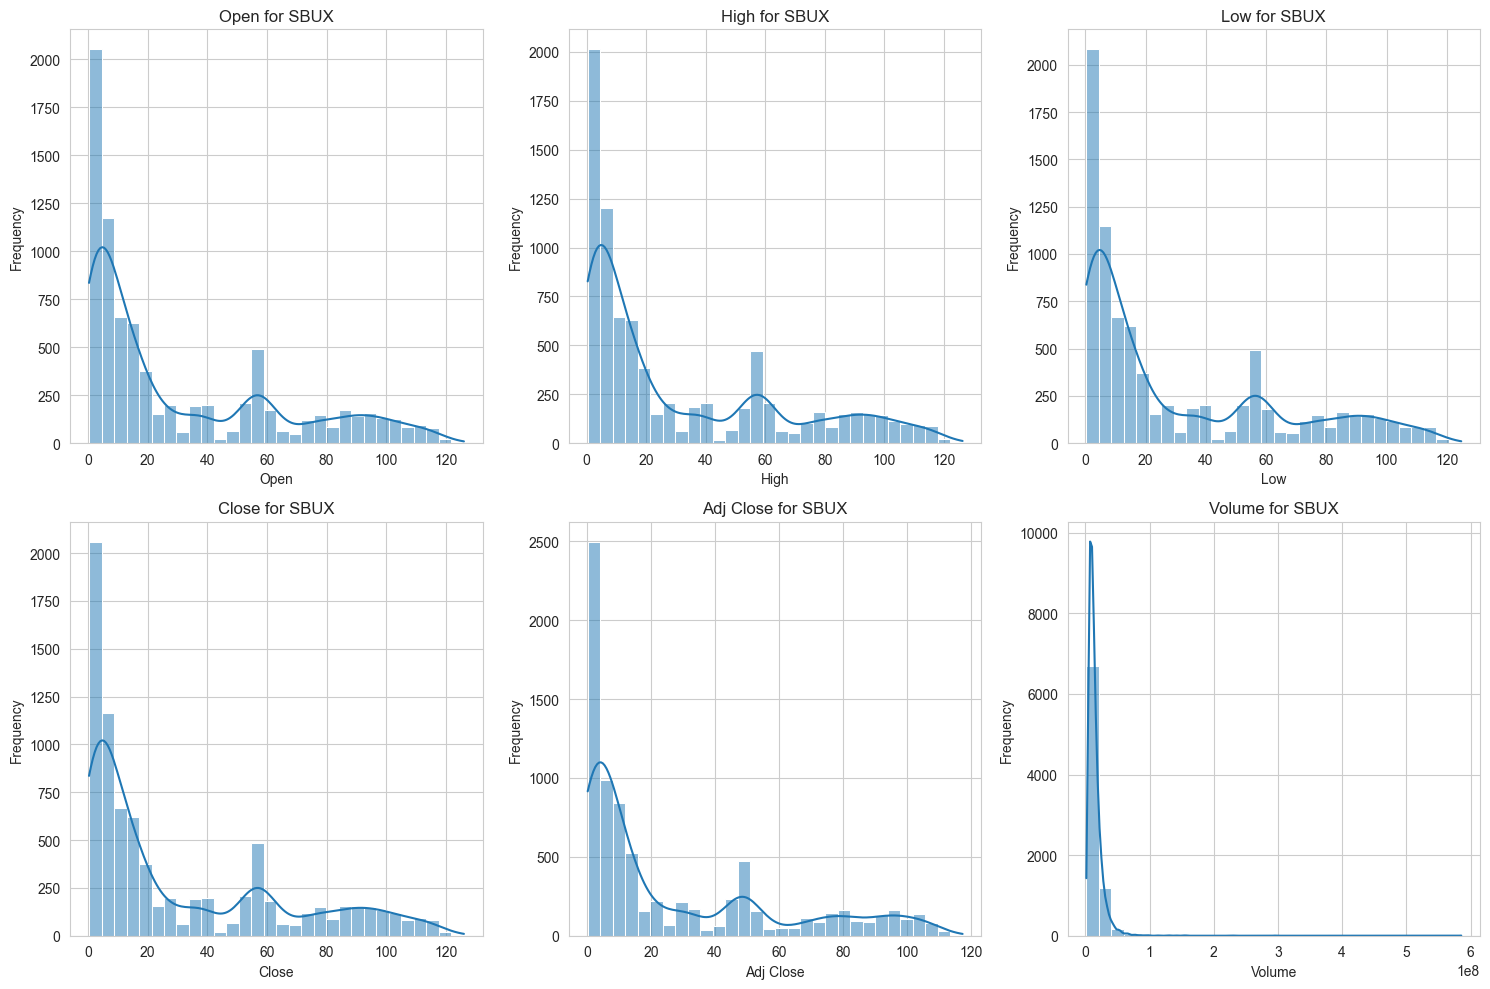

Feature Distributions for WEN


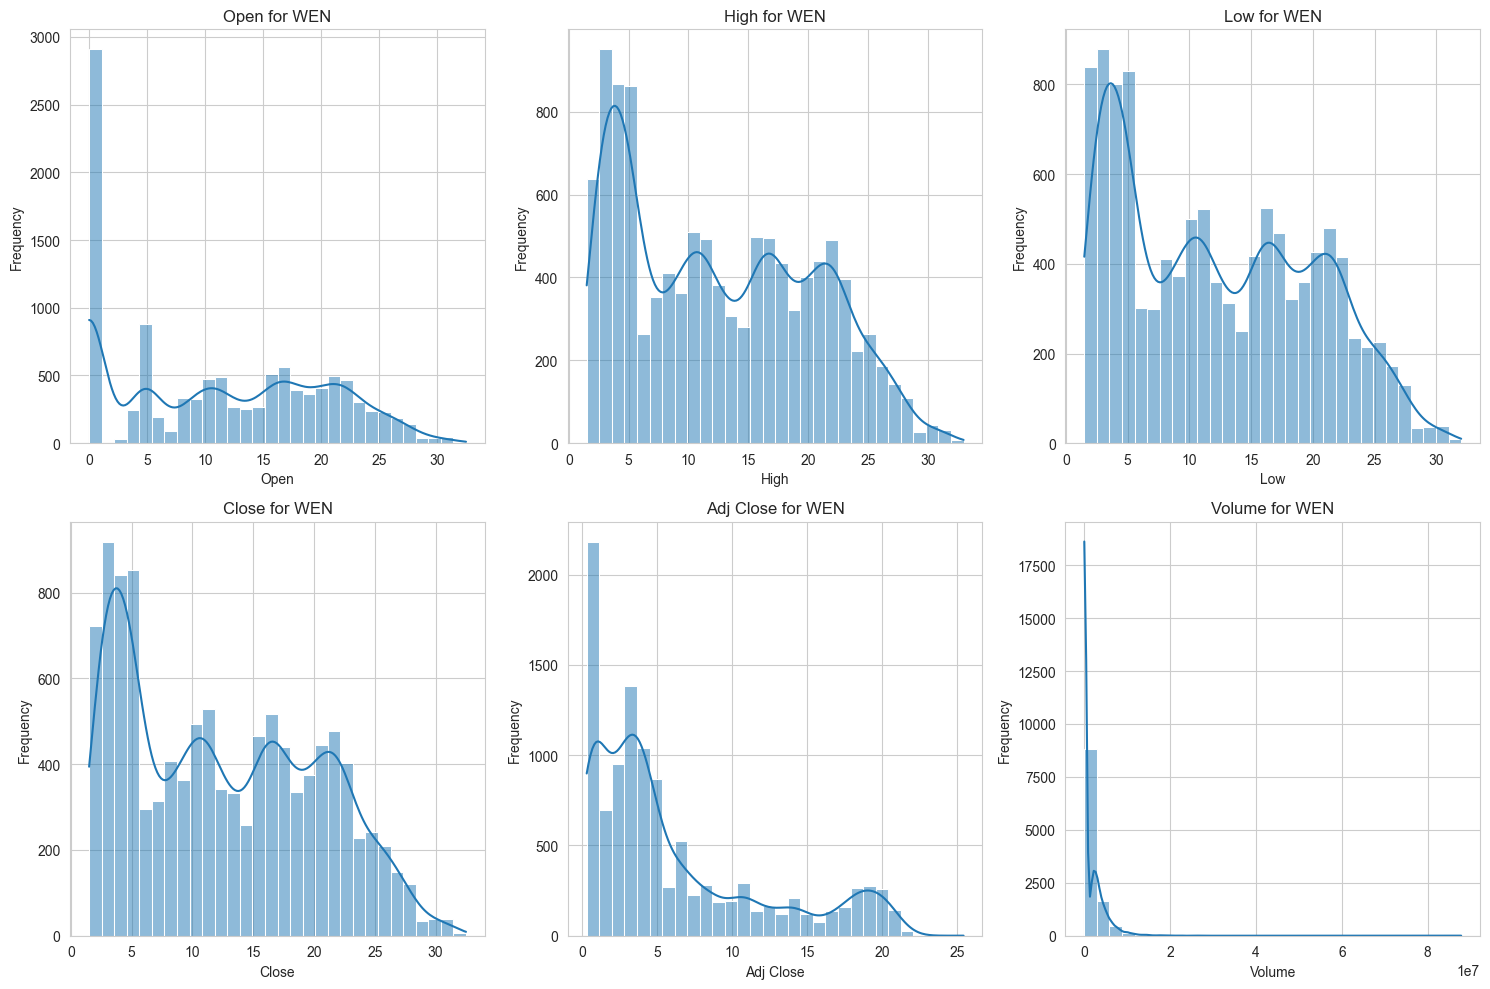

Feature Distributions for YUM


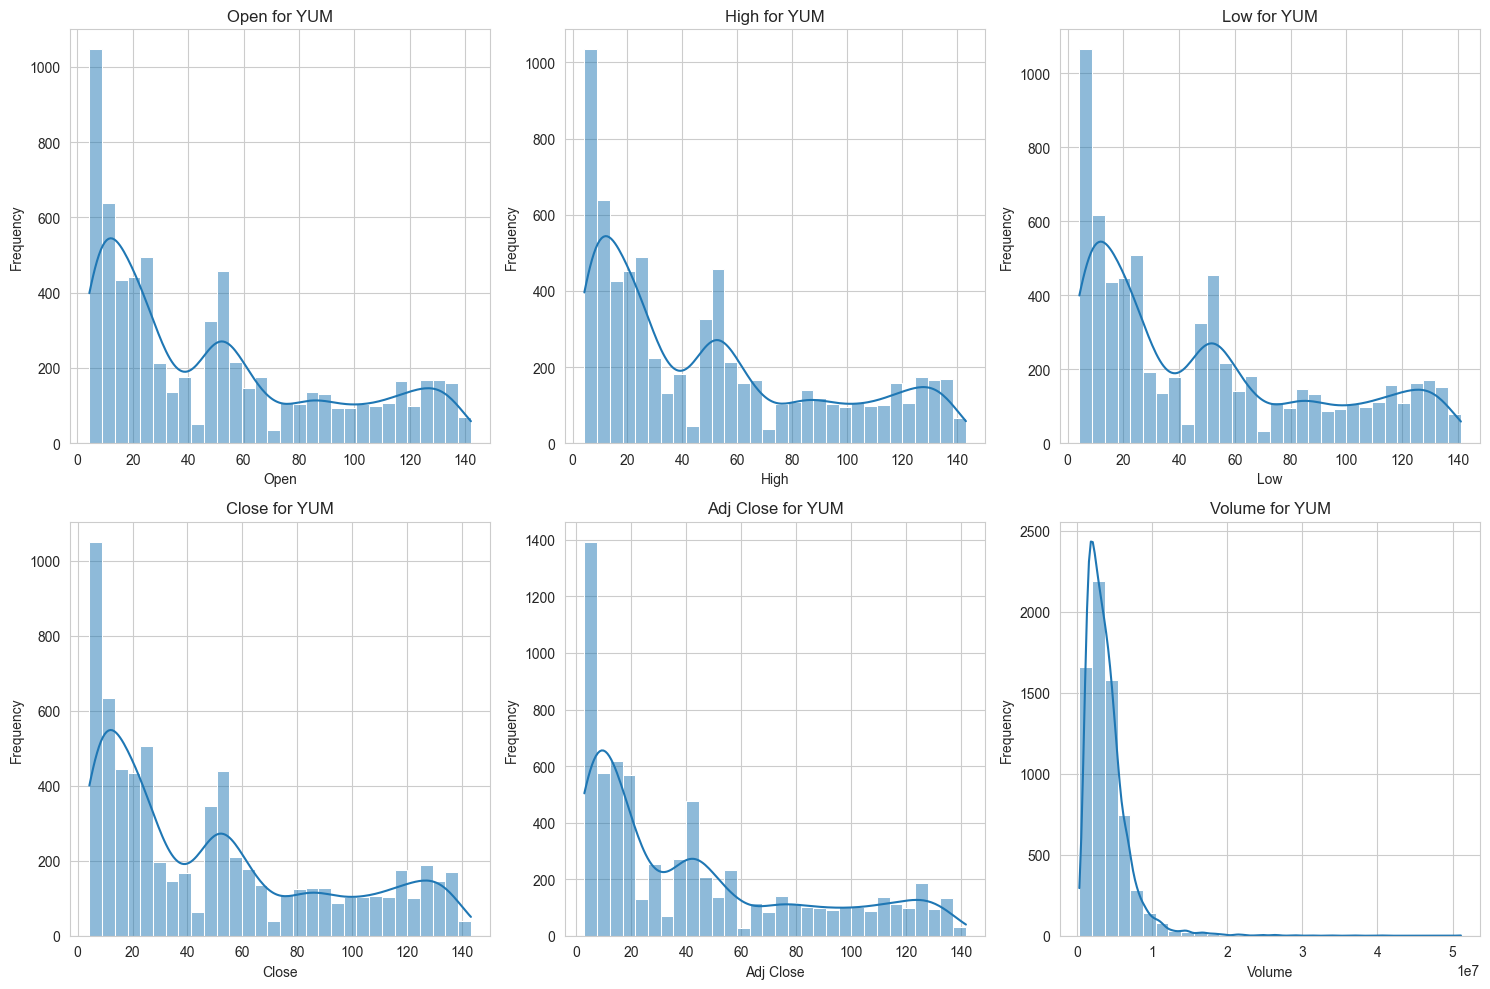

In [39]:
for ticker in stock_tickers:
    print(f"Feature Distributions for {ticker}")
    plot_numerical_features(stock_data[ticker], ticker)

## Time Series Data Analysis

In [ ]:
import mplfinance as mpf

for ticker, df in stock_data.items():
    df.index = pd.to_datetime(df.index)
    # Create dummy columns
    df['Open'] = df['Close']
    df['High'] = df['Close']
    df['Low'] = df['Close']
    renko_data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

    # Plot Renko chart with volume
    mpf.plot(renko_data, type='renko', volume=True, title=f"OHLC and Volume for {ticker}",
             style='yahoo', datetime_format='%Y-%m-%d', figsize=(15, 10))

In [ ]:
df.columns